<a href="https://colab.research.google.com/github/sysbio-unam/practicas-computacionales/blob/main/algoritmo_Gillespie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Algoritmo de Gillespie

Nombre: Biología de sistemas UNAM

Fecha: diciembre 2021

In [2]:
install.packages("deSolve")
library(deSolve)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Descripción del proceso (en este caso, las reacciones): 
El sistema bioquímico de formación y degradación de la GFP a considerar en está dado por las reacciones representadas por:

$$
\varnothing \xrightarrow[]{k_1} \text{GFP} \xrightarrow[]{k_2}  \varnothing \tag{1}
$$

# 1. Establecer modelo y obtener estado estacionario 

## Red para describir las reacciones en las que participa la GFP

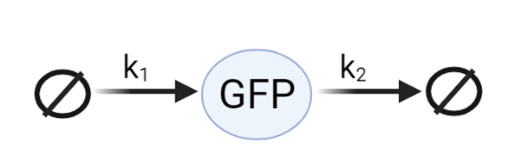

## Modelo matemático 

Realizando el balance de materia para la proteína GFP se tiene

$$
\text{cambio de concentración de la GFP} = \text{entrada de GFP} - \text{degradación de GFP} \tag{2}
$$

$$
\frac{dGFP}{dt} = k_1 s - k_2 GFP \tag{3} 
$$

En (3) se supone que la producción de GFP se realiza a una velocidad constante. Por otro lado, la degradación de la GFP se establece proporcional a su concentración.

Dado que el primer término en (3) es una constante se puede escribir como 

$$
\frac{dGFP}{dt} = p_1 - k_2 GFP \tag{4}
$$

donde $p_1 = k_1 s$

## Análisis de estabilidad 

Igualando (4) a cero y despejando de obtiene el estado estacionario.

$$
\frac{dGFP}{dt} = p_1 - k_2 GFP = 0 \rightarrow GFP_{ss} = \frac{p_1}{k_2}
$$

In [3]:
# calcular estado estacionario 
steady_state <- function(p) {
    with(as.list(p), {
        GFPss <- p1/k2

        return(GFPss)
    })
}

In [4]:
# establecer parámetros 
p <- c(p1 = 2, k2 = 0.1)

# calcular estado estable
GFPss <- steady_state(p)
print(GFPss)

[1] 20


# Algoritmo de Gillespie 

Primero es necesario establecer una función que nos permita calcular las velocidades de reacción en cada instante 


In [5]:
get_rates = function(GFP, rate_const) {

    f = c(rate_const[1], rate_const[2]*GFP)

    return(f)
}

In [6]:
gillespieGFp = function(GFP0, rate_const, get_rates, tend) {

    tvec = vector("numeric") # vector para guardar los tiempos en los que ocurren las rxs

    GFPvec = vector("numeric") # vector para guardar los valores de GFP en el tiempo

    tvec[1] = 0 # tiempo inicial 

    GFPvec[1] = GFP0 # GFP inicial 

    while (tvec[length(tvec)] < tend) { # mientras el último valor de tiempo sea menor a tend
        current_GFP = GFPvec[length(GFPvec)] # valor actual de GFP
        rates = get_rates(current_GFP, rate_const) # calcular velocidades de reacción
        rate_sum = sum(rates)

        tau = rexp(1, rate_sum) # tomar el paso de tiempo de una función de distribución exponencial 

        tvec = c(tvec, tvec[length(tvec)] + tau) # nuevo tiempo en el que ocurre la rx

        rx = sample(length(rates), 1, prob = rates) # seleccionar la rxs que ocurrirá con una probabilidad 
        # propoorcional a su velocidad 

        # actualizar valor de GFP
        if (rx == 1) {
            GFPvec = c(GFPvec, GFPvec[length(GFPvec)] + 1) # producción
        }
        else {
            GFPvec = c(GFPvec, GFPvec[length(GFPvec)] - 1) # degradación
        }
    }
    return(list(t = tvec, GFP = GFPvec))

}

In [7]:
# parámetros 
GFP0 = 0 # initial conditions
tend = 100 # tiempo final 
rate_const = p # parameters (rate constants)

In [8]:
# correr algoritmo
out = gillespieGFp(GFP0, rate_const, get_rates, tend)

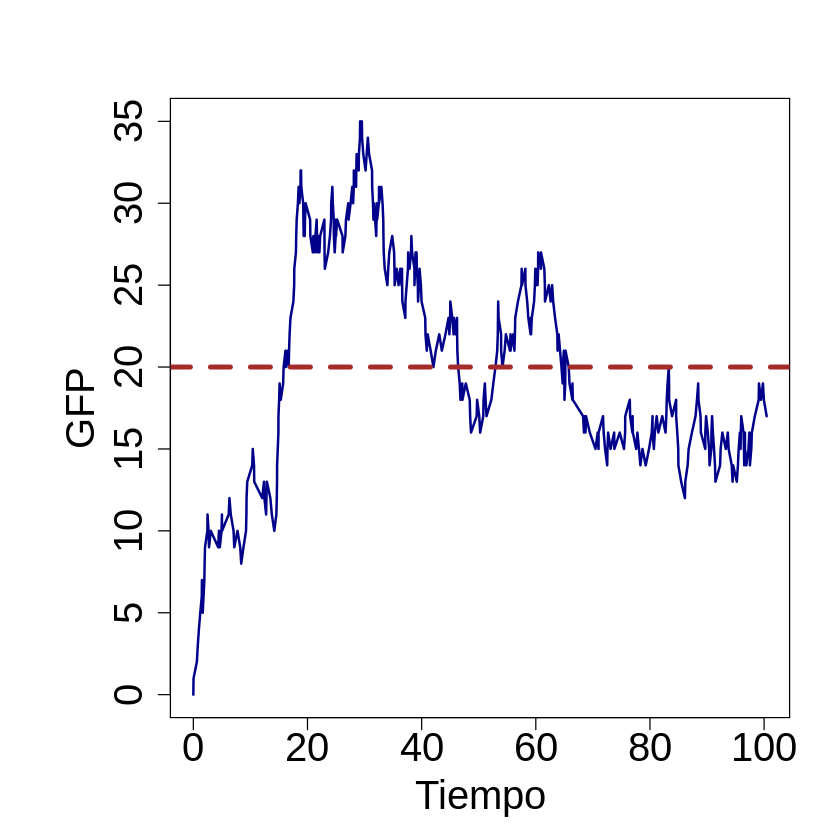

In [9]:
par(mar = c(5,7,4,2) + 0.1)
plot(out$t, out$GFP, type = "l", cex.axis = 2, cex.lab = 2, col = "darkblue", lwd = 2, xlab = "Tiempo", ylab = "GFP")
abline(h = 20, lty = 2, col = "brown", lwd = 4)

## Obtener la concentración final de GFP al realizar varias simulaciones para determinar su distribución

In [10]:
# función para calcular el valor final de GFP
GFP_end <- function(GFP0, rate_const, get_rates, tend) {
        
        out = gillespieGFp(GFP0, rate_const, get_rates, tend)
        
        n <- length(out$GFP)
        
        GFP = out$GFP[n]
        
        return(GFP)
}

In [11]:
GFP_end(GFP0, rate_const, get_rates, tend)

[1] 20

In [12]:
GFP_ends <- replicate(100, {
        
        GFPs = GFP_end(GFP0, rate_const, get_rates, tend)
})

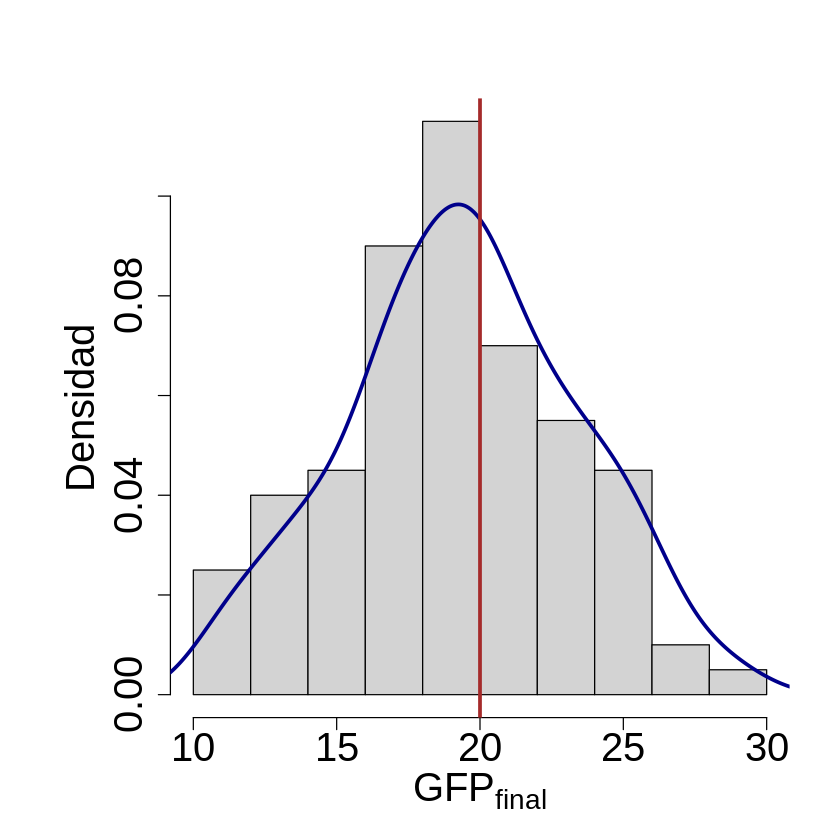

In [13]:
# mostrar distribución
par(mar = c(5,7,4,2) + 0.1)
hist(GFP_ends,prob = TRUE, xlab = expression(GFP[final]), ylab = "Densidad", cex.lab = 2, cex.axis = 2, main = "")
lines(density(GFP_ends), col="darkblue", lwd = 3)
abline(v=GFPss, col="brown", lwd = 3)

## Simular con modelo determinista

In [14]:
# modelo en ED
detGFP <- function(t, state, parms) {
        
        with(as.list(c(state, parms)), {
                
                dGFP <- p1-k2*GFP
                
                return(list(c(dGFP)))
        })
        
}

In [15]:
# tiempo de integración
times <- seq(0,100,1)
# condiciones iniciales 
s <- c(GFP = GFP0)
# parámetros
print(p)

 p1  k2 
2.0 0.1 


In [16]:
# simular mdelo 
outD <- ode(y = s, times = times, func = detGFP, parms = p)

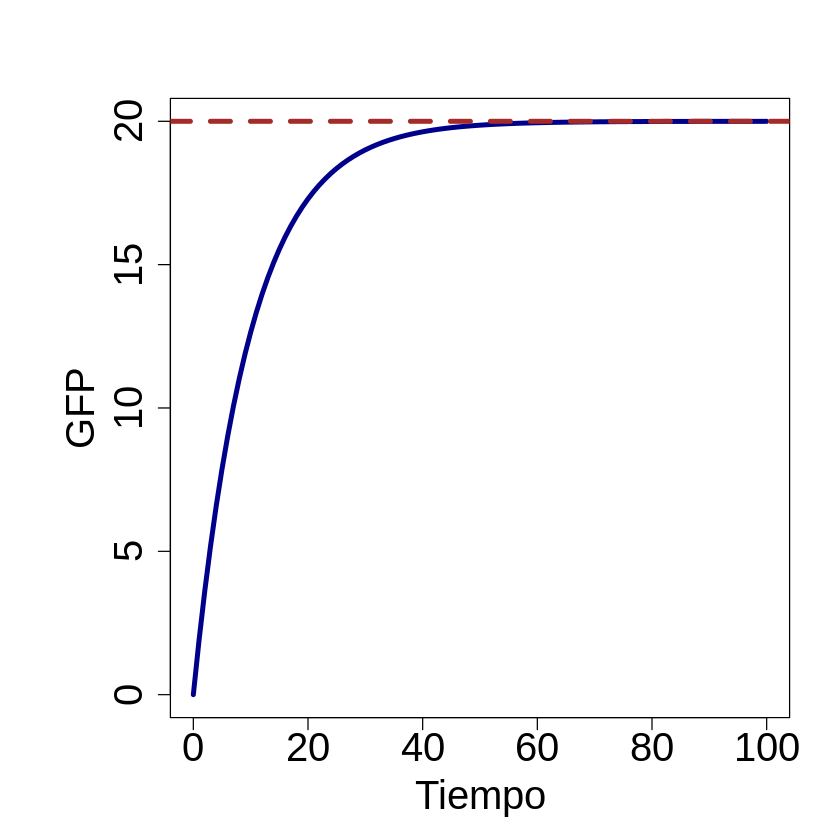

In [17]:
# mostrar resultados 
par(mar = c(5,7,4,2) + 0.1)
plot(outD,type = "l", cex.axis = 2, cex.lab = 2, col = "darkblue", lwd = 4, xlab = "Tiempo", ylab = "GFP", main = "")
abline(h = 20, lty = 2, col = "brown", lwd = 4)

## Ahora empleamos la paquetería en R

In [18]:
install.packages("GillespieSSA")
library(GillespieSSA)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [19]:
# define el cambio en el número de individuos en cada estado (rows) 
# causado por una reacción de un tipo determinado (columns). 
nu = matrix(c(+1,-1),nrow = 1, byrow = TRUE) 

In [20]:
# El vector de propensión, a, define las probabilidades de que ocurra 
# una reacción particular durante el siguiente intervalo de tiempo infinitesimal [t; t + dt]. 
# a = c("c1*X1","c2*X2")
# donde c1 y c2 son las probabilidades de reacción per cápita.
h = c("p1", "k2*GFP")

In [21]:
# simular con la función ssa
x0 = c(GFP = GFPss)
out <- ssa(x0 = x0, a = h, nu = nu, parms = p, tf = tend)

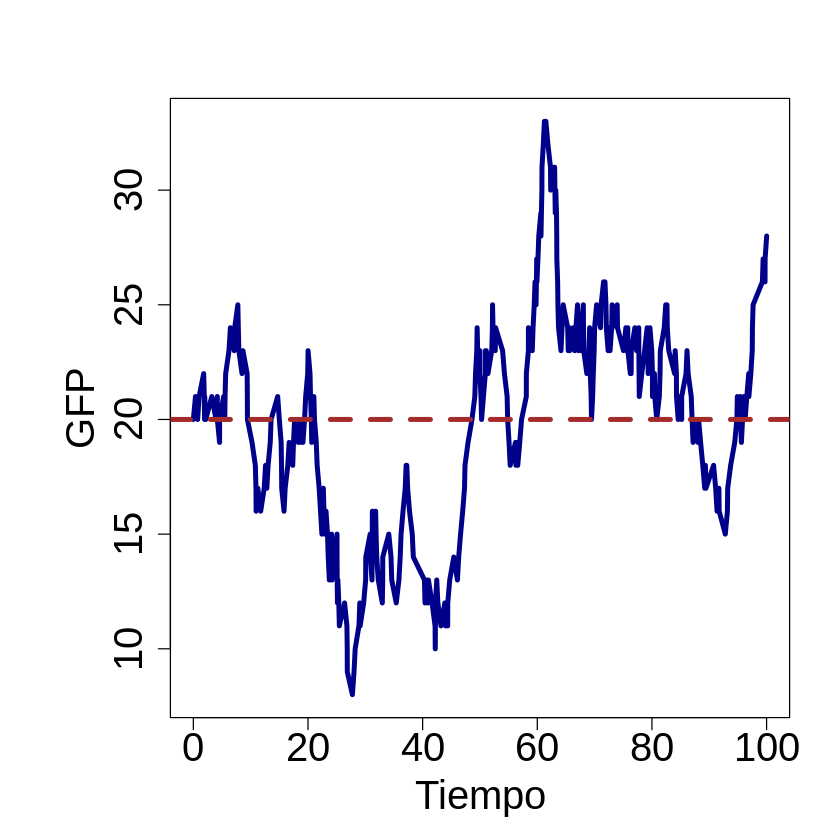

In [22]:
# mostrar resultados 
par(mar = c(5,7,4,2) + 0.1)
plot(out$data[,1], out$data[,2],type = "l", cex.axis = 2, cex.lab = 2, col = "darkblue", lwd = 4, xlab = "Tiempo", ylab = "GFP", main = "")
abline(h = 20, lty = 2, col = "brown", lwd = 4)

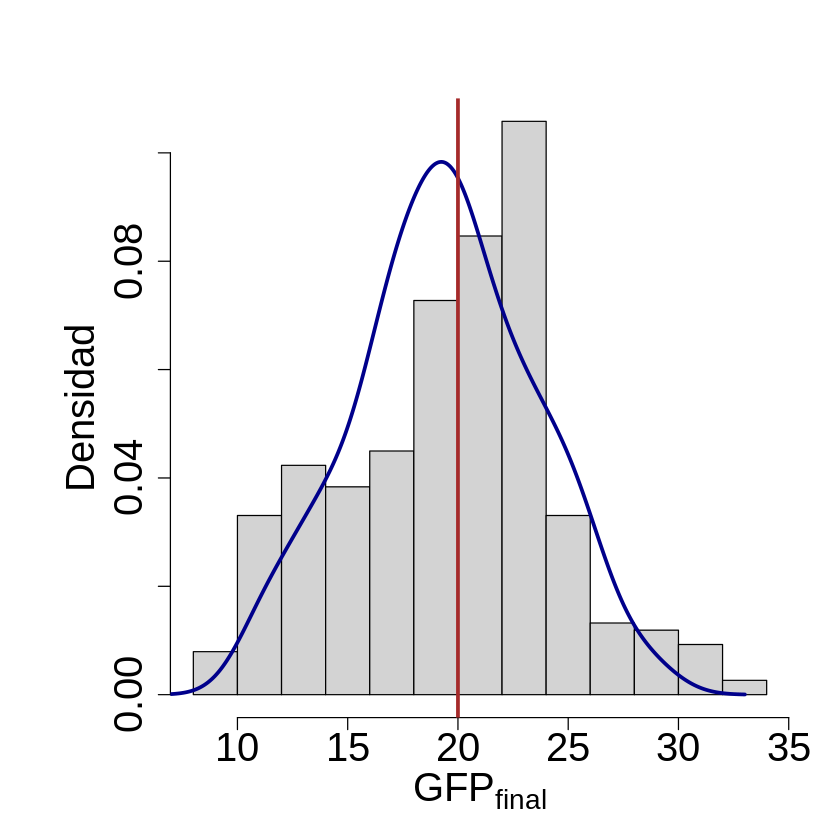

In [23]:
# mostrar distribución 
par(mar = c(5,7,4,2) + 0.1)
hist(out$data[,2],prob = TRUE, xlab = expression(GFP[final]), ylab = "Densidad", cex.lab = 2, cex.axis = 2, main = "")
lines(density(GFP_ends), col="darkblue", lwd = 3)
abline(v=GFPss, col="brown", lwd = 3)